In [80]:
# Core modules
import os
from io import StringIO
from typing import Callable, List, Dict, Any, Tuple
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import numpy as np
import inspect

# Data retrieval
import yfinance as yf

# Plotting modules
import matplotlib.pyplot as plt
import plotly.express as px
import hyperopt.plotting as hplt
from IPython.display import clear_output

# Sklearn ML
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, median_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator

# Keras DL
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Hyperparameter optimisation
from hyperopt import STATUS_OK, fmin, tpe, Trials, hp
from functools import partial

# Cloud services
from azureml.core import Workspace
from azure.storage.blob import BlobServiceClient
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# Tracking
import mlflow
import mlflow.keras
import mlflow.sklearn


In [14]:
# downloading data
data = yf.download("^FTSE", start="1999-12-01", end="2021-12-01")

[*********************100%%**********************]  1 of 1 completed


In [15]:
data.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-17,7327.000000,7327.000000,7290.000000,7291.200195,7291.200195,980280900
2021-11-18,7291.200195,7291.299805,7242.000000,7256.000000,7256.000000,590225200
2021-11-19,7256.000000,7289.500000,7198.799805,7223.600098,7223.600098,1174484200
2021-11-22,7223.600098,7272.600098,7207.799805,7255.500000,7255.500000,638191500
2021-11-23,7255.500000,7293.100098,7204.399902,7266.700195,7266.700195,624614500
2021-11-24,7266.700195,7307.899902,7246.000000,7286.299805,7286.299805,661514300
2021-11-25,7286.299805,7311.899902,7286.299805,7310.399902,7310.399902,487924100
2021-11-26,7310.399902,7310.399902,7042.100098,7044.000000,7044.000000,1714871800
2021-11-29,7044.000000,7161.899902,7044.000000,7110.000000,7110.000000,945061900


In [16]:
print(data.isnull().sum())
print(data.eq(0).sum())
print(data.index.diff().value_counts().sort_index())


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date
1 days    4391
2 days      11
3 days    1039
4 days      75
5 days      41
Name: count, dtype: int64


In [17]:
fig = px.line(data, x=data.index, y='Adj Close')
fig.update_layout(title={'text': 'Closing price over time', 'x': 0.5})
fig.show()

In [83]:
class KerasLogger:

    def __init__(self, run_name: str):
        self.run_name = run_name

    def __call__(self, func: Callable):

        def wrapper(*args, **kwargs):
            with mlflow.start_run(run_name=self.run_name):
                
                mlflow.keras.autolog()
                model, y_test, y_pred, losses = func(*args, **kwargs)

                metrics = self.get_metrics(y_pred, y_test)
                mlflow.log_metrics(metrics)

                mlflow.keras.log_model(model, artifact_path="models")

                lossplt = self.plot_true_value_vs_prediction(y_pred, y_test)
                mlflow.log_figure(lossplt, "true_value_vs_prediction.png")

                epochplt = self.plot_loss_over_epoch(losses)
                mlflow.log_figure(epochplt, "loss_over_epochs.png")

                return model, y_test, y_pred, losses
        
        return wrapper

        
    @staticmethod
    def plot_true_value_vs_prediction(pred: np.ndarray, test: np.ndarray) -> plt.figure:
        fig, ax = plt.subplots()
        ax.plot(test, label='True Value')
        ax.plot(pred, label='LSTM Value')
        ax.set_title('Prediction by LSTM')
        ax.set_xlabel('Time Scale')
        ax.set_ylabel('Scaled USD')
        ax.legend()
        return fig

    @staticmethod
    def plot_loss_over_epoch(losses: List[float]) -> plt.figure:
        fig, ax = plt.subplots()
        ax.plot(losses)
        ax.set_title('Model Loss Over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        return fig
    
    @staticmethod
    def get_metrics(pred: np.ndarray, test: np.ndarray) -> Dict[str, float]:
        mse = mean_squared_error(test, pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test, pred)
        r2 = r2_score(test, pred)
        msle = mean_squared_log_error(test, pred)
        medae = median_absolute_error(test, pred)
        return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "msle": msle, "medae": medae}

In [93]:
runname = "aalstm"

## Building LSTM mode
@KerasLogger(run_name=runname)
def train_lstm_model(df: pd.DataFrame,
                test_size: int = 10,
                loss: str = 'mean_squared_error',
                activation: str = 'relu',
                optimiser: str = 'adam',
                n_epoch: int = 100,
                batch_size: int = 8,
                verbose: int = 1) -> Tuple[Sequential, np.ndarray, np.ndarray, List[float]]:

    # defome featires, target
    X, y = df.drop('Adj Close', axis=1), data[['Adj Close']]

    # svale features
    X_scaled = MinMaxScaler().fit_transform(X)
    X = pd.DataFrame(data=X_scaled, columns=X.columns, index=X.index)

    #Building the LSTM Model
    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, X.shape[1]), activation=activation, return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss=loss, optimizer=optimiser)

    n_split = 100 // test_size - 1
    timesplit = TimeSeriesSplit(n_splits=n_split)

    losses = []
    for i, (train_idx, test_idx) in enumerate(timesplit.split(X)):
        print(f"\n\n---Training model batch {i+1} out of {n_split}---")
        X_train = X[:len(train_idx)]
        X_test = X[len(train_idx): (len(train_idx)+len(test_idx))]
        y_train = y[:len(train_idx)].values.ravel()
        y_test = y[len(train_idx): (len(train_idx)+len(test_idx))].values.ravel()

        # reshapiong
        X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
        hist = lstm.fit(X_train, y_train, epochs=n_epoch, batch_size=batch_size, verbose=verbose)
        losses.extend(hist.history['loss'])
    
    X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])
    y_pred = lstm.predict(X_test)
    return lstm, y_test, y_pred, losses

In [20]:
mlflow.set_experiment(experiment_name="demo4")

2024/01/15 17:23:21 INFO mlflow.tracking.fluent: Experiment with name 'demo4' does not exist. Creating a new experiment.


<Experiment: artifact_location='', creation_time=1705339403674, experiment_id='d2f4cd6e-b006-4000-9b48-2f1916d8f10a', last_update_time=None, lifecycle_stage='active', name='demo4', tags={}>



---Training model batch 1 out of 3---
Epoch 1/5
174/174 [==============================] - 3s 15ms/step - loss: 26124568.0000
Epoch 2/5
174/174 [==============================] - 0s 1ms/step - loss: 26078440.0000
Epoch 3/5
174/174 [==============================] - 0s 2ms/step - loss: 25958852.0000
Epoch 4/5
174/174 [==============================] - 0s 2ms/step - loss: 25775666.0000
Epoch 5/5
1/1 [==============================] - 0s 161ms/step


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmp3izvbup8\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmp3izvbup8\model\data\model\assets
2024/01/15 17:24:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."




---Training model batch 2 out of 3---


2024/01/15 17:24:36 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: INVALID_PARAMETER_VALUE: Response: {'Error': {'Code': 'ValidationError', 'Severity': None, 'Message': 'A given key of Inputs can not modify its value after it is set', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': None, 'Details': [], 'InnerError': None, 'DebugInfo': None, 'AdditionalInfo': None}, 'Correlation': {'operation': 'd148017a6daa5b3a49705ac861a794d5', 'request': '325a9d23af3be32c'}, 'Environment': 'uksouth', 'Location': 'uksouth', 'Time': '2024-01-15T17:24:35.9185414+00:00', 'ComponentName': 'mlflow', 'statusCode': 400, 'error_code': 'INVALID_PARAMETER_VALUE'}
2024/01/15 17:25:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model_summary.txt already exists.


Epoch 1/5
  1/348 [..............................] - ETA: 9s - loss: 27826198.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_train_batch_end` time: 0.0035s). Check your callbacks.


348/348 [==============================] - 2s 7ms/step - loss: 27376106.0000
Epoch 2/5
348/348 [==============================] - 0s 1ms/step - loss: 26581982.0000
Epoch 3/5
348/348 [==============================] - 0s 1ms/step - loss: 25678022.0000
Epoch 4/5
348/348 [==============================] - 0s 1ms/step - loss: 24678170.0000
Epoch 5/5
1/1 [==============================] - 0s 16ms/step


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmpwcu3j31k\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmpwcu3j31k\model\data\model\assets
2024/01/15 17:25:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model/conda.yaml already exists.
UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model/MLmodel already exists.
UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model/python_env.yaml already exists.
UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model/requirements.txt already exists.
UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model/data/global_custom_objects.cloudpickle already exists.
UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-654



---Training model batch 3 out of 3---


2024/01/15 17:25:16 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: INVALID_PARAMETER_VALUE: Response: {'Error': {'Code': 'ValidationError', 'Severity': None, 'Message': 'A given key of Inputs can not modify its value after it is set', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': None, 'Details': [], 'InnerError': None, 'DebugInfo': None, 'AdditionalInfo': None}, 'Correlation': {'operation': 'ce49b6e567ac59fc3b0b1255b94c214d', 'request': '5017a12ea51ba23e'}, 'Environment': 'uksouth', 'Location': 'uksouth', 'Time': '2024-01-15T17:25:16.4785843+00:00', 'ComponentName': 'mlflow', 'statusCode': 400, 'error_code': 'INVALID_PARAMETER_VALUE'}
2024/01/15 17:25:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model_summary.txt already exists.


Epoch 1/5
  1/522 [..............................] - ETA: 9s - loss: 24622736.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_train_batch_end` time: 0.0022s). Check your callbacks.


522/522 [==============================] - 3s 5ms/step - loss: 24657476.0000
Epoch 2/5
522/522 [==============================] - 1s 1ms/step - loss: 22440236.0000
Epoch 3/5
522/522 [==============================] - 1s 1ms/step - loss: 20204088.0000
Epoch 4/5
522/522 [==============================] - 1s 1ms/step - loss: 17961776.0000
Epoch 5/5
1/1 [==============================] - 0s 18ms/step


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmprhziwecp\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmprhziwecp\model\data\model\assets
2024/01/15 17:25:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model/conda.yaml already exists.
UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model/MLmodel already exists.
UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model/python_env.yaml already exists.
UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model/requirements.txt already exists.
UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-6546413102d5/model/data/global_custom_objects.cloudpickle already exists.
UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.9f297f68-d9fa-4714-a98b-654

44/44 [==============================] - 0s 735us/step


2024/01/15 17:25:57 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmpht5epgvr\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmpht5epgvr\model\data\model\assets


(<keras.engine.sequential.Sequential at 0x27e65e12d50>,
 array([6284.5       , 6301.5       , 6231.89990234, ..., 7044.        ,
        7110.        , 7059.5       ]),
 array([[2069.7986],
        [2063.9692],
        [2056.3428],
        ...,
        [2626.2537],
        [2488.4465],
        [2541.2947]], dtype=float32),
 [26124568.0,
  26078440.0,
  25958852.0,
  25775666.0,
  25543880.0,
  27376106.0,
  26581982.0,
  25678022.0,
  24678170.0,
  23598984.0,
  24657476.0,
  22440236.0,
  20204088.0,
  17961776.0,
  15734713.0])

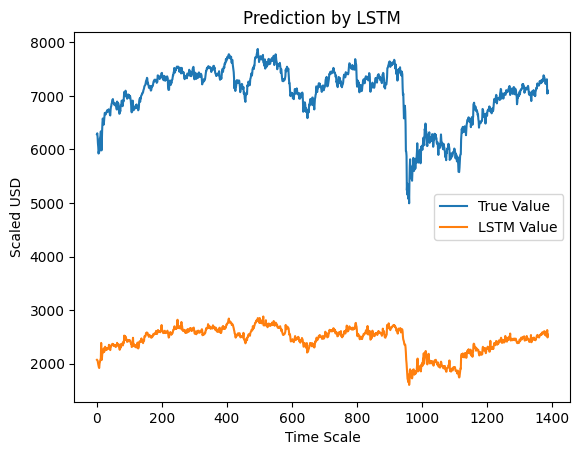

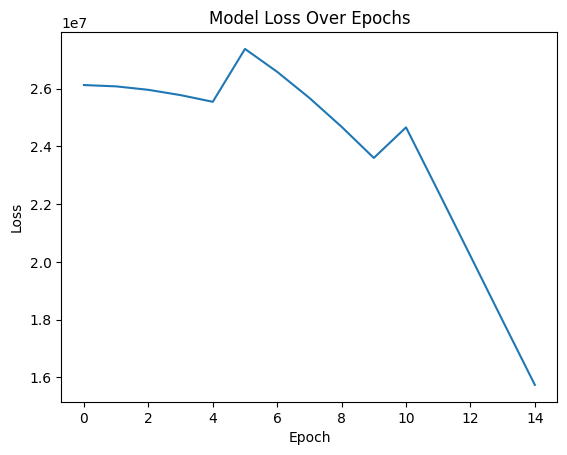

In [21]:
train_lstm_model(data, n_epoch=5, test_size=25)

In [22]:
def train_model(hyperparams: Dict[str, Any],
                X_train: pd.DataFrame,
                X_test: pd.DataFrame,
                y_train: pd.Series,
                y_test: pd.Series,
                model: BaseEstimator,
                dtypes: Dict[str, Callable]) -> Dict[str, Any]:
    
    # map datatypes
    for k, v in hyperparams.items():
        if k in dtypes.keys():
            hyperparams[k] = dtypes[k](v)
    
    model = model(**hyperparams)
    hypervals = '_'.join([f'{key}: {value}' for key, value in hyperparams.items()])
    run_name = f"{type(model).__name__}_{hypervals}"
    with mlflow.start_run(nested=True, run_name=run_name) as child_run:
        
        mlflow.sklearn.autolog()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        msle = mean_squared_log_error(y_test, y_pred)
        medae = median_absolute_error(y_test, y_pred)

        mlflow.log_metrics({"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "msle": msle, "medae": medae})
    
        return {'status': STATUS_OK, 'loss': mse, "attachments": {"run_id": child_run.info.run_id}}


In [23]:
from dataclasses import dataclass

@dataclass(frozen=True)
class ChildRunData:
    params: Dict[str, Any]
    metrics: Dict[str, float]
    model: BaseEstimator
    run_id: str
    run_name: str
    experiment_id: str

    @classmethod
    def get(cls, run_id):
        client = mlflow.tracking.MlflowClient()
        run = mlflow.get_run(run_id)
        metrics = run.data.metrics
        params = run.data.params
        models = client.download_artifacts(run_id, path="model")
        run_name = run.info.run_name
        experiment_id = run.info.experiment_id

        return cls(params, metrics, models, run_id, run_name, experiment_id)

In [24]:

def search(hyperparam_space: Dict[str, Any],
           df: pd.DataFrame,
           target: str,
           model: BaseEstimator,
           dtypes: Dict[str, Callable],
           max_evals: int = 100) -> Tuple[Trials, Dict[str, Any]]:

    X, y = df.drop(target, axis=1), df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    with mlflow.start_run(nested=False, run_name=model.__name__):
        trials = Trials()
        best_params = fmin(
            fn=partial(
                train_model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, model=model, dtypes=dtypes
                ),
            space=hyperparam_space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=max_evals
        )

        best_run_id = trials.trial_attachments(trials.best_trial)["run_id"]
        best_run_data = ChildRunData.get(best_run_id)

        mlflow.log_param("best_run_id", best_run_id)
        mlflow.log_params({f"best_{p}": v for p, v in best_params.items()})
        mlflow.log_metric("best_mse", trials.best_trial["result"]["loss"])
        mlflow.log_metrics(best_run_data.metrics)
        mlflow.log_artifacts(local_dir=best_run_data.model, artifact_path="model")

        fig = plt.figure()
        fig.add_subplot()
        hplt.main_plot_histogram(trials, do_show=False)
        mlflow.log_figure(fig, "loss_histogram.png")

        return trials, best_params


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2024/01/15 17:26:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:26:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:26:29 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': No

 10%|█         | 1/10 [00:23<03:29, 23.27s/trial, best loss: 321056.2330237715]

2024/01/15 17:26:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:27:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:27:05 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': No

 20%|██        | 2/10 [01:00<04:10, 31.34s/trial, best loss: 321056.2330237715]

2024/01/15 17:27:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:27:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:27:27 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': No

 30%|███       | 3/10 [01:20<03:04, 26.32s/trial, best loss: 321056.2330237715]

2024/01/15 17:27:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:27:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:27:47 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': No

 40%|████      | 4/10 [01:40<02:22, 23.71s/trial, best loss: 321056.2330237715]

2024/01/15 17:27:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:28:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:28:06 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': No

 50%|█████     | 5/10 [01:59<01:50, 22.12s/trial, best loss: 321056.2330237715]

2024/01/15 17:28:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:28:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:28:26 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': No

 60%|██████    | 6/10 [02:19<01:25, 21.33s/trial, best loss: 321056.2330237715]

2024/01/15 17:28:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:28:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:28:45 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': No

 70%|███████   | 7/10 [02:39<01:02, 20.79s/trial, best loss: 321056.2330237715]

2024/01/15 17:28:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:29:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:29:06 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': No

 80%|████████  | 8/10 [02:59<00:41, 20.62s/trial, best loss: 321056.2330237715]

2024/01/15 17:29:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:29:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:29:28 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': No

 90%|█████████ | 9/10 [03:22<00:21, 21.32s/trial, best loss: 321056.2330237715]

2024/01/15 17:29:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:29:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:29:48 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': No

100%|██████████| 10/10 [03:41<00:00, 22.17s/trial, best loss: 321056.2330237715]


c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Showing Histogram of 10 jobs
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2024/01/15 17:30:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:30:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 17:30:30 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': No

 10%|█         | 1/10 [00:23<03:33, 23.76s/trial, best loss: 255958.58188657343]

2024/01/15 17:30:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 10%|█         | 1/10 [00:44<06:38, 44.27s/trial, best loss: 255958.58188657343]


KeyboardInterrupt: 

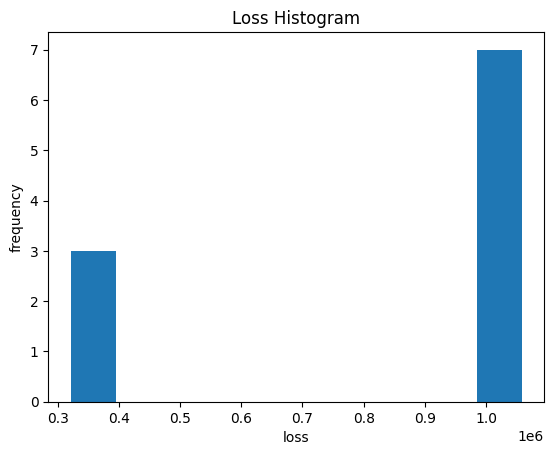

In [25]:


rfspace = {
    "n_estimators": hp.uniform("n_estimators", 200, 1000),
    "max_depth": hp.quniform("max_depth", 10, 1200, 10),
    "min_samples_split": hp.uniform("min_samples_split", 0.1, 1.0),
    "min_samples_leaf": hp.uniform("min_samples_leaf", 0.1, 0.5),
    "max_features": hp.choice("max_features", options=[None, 'sqrt', 'log2']),
    "criterion": hp.choice("criterion", ['squared_error', 'poisson', 'absolute_error', 'friedman_mse'])
}


gbmspace = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', [None, hp.quniform('max_depth_val', 3, 10, 1)]),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
}


rfdtypes = {"max_depth": lambda x: int(x), "n_estimators": lambda x: int(x)}
gbmdtypes = {"max_depth": lambda x: int(x) if x is not None else x, "n_estimators": lambda x: int(x)}

data = data.astype(float)

models = [RandomForestRegressor, GradientBoostingRegressor]
for model, grid, dtype in zip(models, [rfspace, gbmspace], [rfdtypes, gbmdtypes]):
    search(grid, data, 'Adj Close', model, dtype, max_evals=10)


In [ ]:
last_run = mlflow.last_active_run()
child_runs = mlflow.search_runs(
    filter_string=f"tags.mlflow.parentRunId='{last_run.info.run_id}'"
)
with pd.option_context("display.max_columns", None):
    print(child_runs.sort_values(by='metrics.mae'))

In [ ]:
workspace = Workspace.from_config()
repr(workspace)

"Workspace.create(name='daadspocs', subscription_id='b501a57e-71d5-4887-b72c-a0c961a0f281', resource_group='uk-environment')"

In [3]:
# creating data store within workspace
load_dotenv(find_dotenv())
connection_string = os.environ.get('AZURE_STORAGE_CONNECTION_STRING')
container = os.environ.get('CONTAINER_NAME')

blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container)

main_blob_name = 'ftse100data.csv'

In [4]:
def save_data_to_blob(blob_name: str, df: pd.DataFrame, overwrite: bool = True) -> None:
    container_client.upload_blob(name=blob_name, data=df.to_csv(), overwrite=overwrite)

def read_data_from_blob(blob_name: str) -> pd.DataFrame:
    blob_client = container_client.get_blob_client(blob_name)
    data = blob_client.download_blob().readall().decode('utf-8')
    df = pd.read_csv(StringIO(data), parse_dates=['Date'])
    return df.set_index('Date')

data = read_data_from_blob(main_blob_name)
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-24,7266.700195,7307.899902,7246.000000,7286.299805,7286.299805,6.615143e+08
2021-11-25,7286.299805,7311.899902,7286.299805,7310.399902,7310.399902,4.879241e+08
2021-11-26,7310.399902,7310.399902,7042.100098,7044.000000,7044.000000,1.714872e+09
2021-11-29,7044.000000,7161.899902,7044.000000,7110.000000,7110.000000,9.450619e+08
2021-11-30,7110.000000,7110.000000,6989.700195,7059.500000,7059.500000,1.459578e+09


In [5]:
credential = DefaultAzureCredential()
mlclient = MLClient.from_config(credential)

Found the config file in: .\config.json


In [6]:
ws_name = mlclient.workspace_name
tracking_uri = mlclient.workspaces.get(ws_name).mlflow_tracking_uri
mlflow.set_tracking_uri(tracking_uri)

In [32]:
exp = mlflow.get_experiment_by_name('demo4')
last_run = mlflow.search_runs(exp.experiment_id)
our_run = last_run.loc[last_run['tags.mlflow.runName'] == 'RandomForestRegressor'].squeeze()
rid = our_run.run_id
with pd.option_context("display.max_rows", None): print(our_run)

run_id                                      5727663c-084e-4c18-a007-b8d69d67691d
experiment_id                               d2f4cd6e-b006-4000-9b48-2f1916d8f10a
status                                                                  FINISHED
artifact_uri                                                                    
start_time                                      2024-01-15 17:26:09.370000+00:00
end_time                                        2024-01-15 17:30:09.125000+00:00
metrics.msle                                                            0.010807
metrics.rmse                                                          566.618243
metrics.mse                                                        321056.233024
metrics.loss                                                                 NaN
metrics.mae                                                           486.152783
metrics.r2                                                               0.69373
metrics.medae               

In [33]:
artifact_path = "model"
mlflow.register_model(f"runs:/{rid}/{artifact_path}", "lstm")

Registered model 'lstm' already exists. Creating a new version of this model...
2024/01/15 17:50:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lstm, version 1
Created version '1' of model 'lstm'.


<ModelVersion: aliases=[], creation_timestamp=1705341048135, current_stage='None', description='', last_updated_timestamp=1705341048135, name='lstm', run_id='5727663c-084e-4c18-a007-b8d69d67691d', run_link='', source='azureml://uksouth.api.azureml.ms/mlflow/v2.0/subscriptions/b501a57e-71d5-4887-b72c-a0c961a0f281/resourceGroups/uk-environment/providers/Microsoft.MachineLearningServices/workspaces/daadspocs/experiments/d2f4cd6e-b006-4000-9b48-2f1916d8f10a/runs/5727663c-084e-4c18-a007-b8d69d67691d/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [34]:
client = mlflow.tracking.MlflowClient()
for model in client.search_registered_models():
    print(f"{model.name}")

azureml_boring_cassava_smcw7bv63h_output_mlflow_log_model_548350309
azureml_boring_cassava_smcw7bv63h_output_mlflow_log_model_1700531275
credit_defaults_model
amlstudio-predict-auto-price
azureml_AutoML_cb7a19de-94bb-40e3-a109-6e2330f4023e_0_output_mlflow_log_model_805459951
AutoMLcb7a19de90
amlstudio-predict-diabetes
azureml_5a48cbc5-ac10-4512-bb9f-4d6ac06c4468_output_mlflow_log_model_503845975
azureml_loving_machine_3r8228hz83_output_mlflow_log_model_503845975
diabetes-mlflow
azureml_9f297f68-d9fa-4714-a98b-6546413102d5_output_mlflow_log_model_1899327965
azureml_9f297f68-d9fa-4714-a98b-6546413102d5_output_mlflow_log_model_1938168045
azureml_6651ba31-eeac-4b4d-a021-39659af5ba27_output_mlflow_log_model_613564256
azureml_e84dddfe-1b66-4fa8-a8a0-c1c720cceed4_output_mlflow_log_model_613564256
azureml_e0299110-ad86-4156-9a20-575cf5c8730d_output_mlflow_log_model_613564256
azureml_e01e8cb3-4cc6-4d0e-8afd-ecc644103688_output_mlflow_log_model_613564256
azureml_d947dee0-32e9-4bbf-bffc-4030fca49

In [36]:
client.search_registered_models(f"name='lstm'")

[<RegisteredModel: aliases={}, creation_timestamp=1705340501921, description='', last_updated_timestamp=1705340501921, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1705341048135, current_stage='None', description='', last_updated_timestamp=1705341048135, name='lstm', run_id='5727663c-084e-4c18-a007-b8d69d67691d', run_link='', source='azureml://uksouth.api.azureml.ms/mlflow/v2.0/subscriptions/b501a57e-71d5-4887-b72c-a0c961a0f281/resourceGroups/uk-environment/providers/Microsoft.MachineLearningServices/workspaces/daadspocs/experiments/d2f4cd6e-b006-4000-9b48-2f1916d8f10a/runs/5727663c-084e-4c18-a007-b8d69d67691d/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>], name='lstm', tags={}>]

In [38]:
client.search_model_versions(f"name='lstm'")

[<ModelVersion: aliases=[], creation_timestamp=1705341048135, current_stage='None', description='', last_updated_timestamp=1705341048135, name='lstm', run_id='5727663c-084e-4c18-a007-b8d69d67691d', run_link='', source='azureml://uksouth.api.azureml.ms/mlflow/v2.0/subscriptions/b501a57e-71d5-4887-b72c-a0c961a0f281/resourceGroups/uk-environment/providers/Microsoft.MachineLearningServices/workspaces/daadspocs/experiments/d2f4cd6e-b006-4000-9b48-2f1916d8f10a/runs/5727663c-084e-4c18-a007-b8d69d67691d/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>]

In [39]:
client.get_model_version_stages('lstm', version="latest")

C:\Users\a913788\AppData\Local\Temp\ipykernel_16304\673679136.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_model_version_stages`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  client.get_model_version_stages('lstm', version="latest")


['None', 'Staging', 'Production', 'Archived']

In [40]:
client.search_registered_models(f"name='diabetes-mlflow'")

[<RegisteredModel: aliases={}, creation_timestamp=1684491897929, description='', last_updated_timestamp=1684491897929, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1684491897954, current_stage='None', description='', last_updated_timestamp=1684491897954, name='diabetes-mlflow', run_id='', run_link='', source='', status='READY', status_message='', tags={}, user_id='', version='1'>], name='diabetes-mlflow', tags={}>]

In [45]:
client.transition_model_version_stage('lstm', version=1, stage='Staging', archive_existing_versions=True)

C:\Users\a913788\AppData\Local\Temp\ipykernel_16304\710718729.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  client.transition_model_version_stage('lstm', version=1, stage='Staging', archive_existing_versions=True)


<ModelVersion: aliases=[], creation_timestamp=1705341048135, current_stage='Staging', description='', last_updated_timestamp=1705341645267, name='lstm', run_id='5727663c-084e-4c18-a007-b8d69d67691d', run_link='', source='azureml://uksouth.api.azureml.ms/mlflow/v2.0/subscriptions/b501a57e-71d5-4887-b72c-a0c961a0f281/resourceGroups/uk-environment/providers/Microsoft.MachineLearningServices/workspaces/daadspocs/experiments/d2f4cd6e-b006-4000-9b48-2f1916d8f10a/runs/5727663c-084e-4c18-a007-b8d69d67691d/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [47]:
latest_mv = client.get_latest_versions('lstm', stages=['Staging'])[0]
client.set_registered_model_alias('lstm', 'prototype', latest_mv.version)

C:\Users\a913788\AppData\Local\Temp\ipykernel_16304\1460337553.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  latest_mv = client.get_latest_versions('lstm', stages=['Staging'])[0]


MlflowException: API request to endpoint /api/2.0/mlflow/registered-models/alias failed with error code 404 != 200. Response body: ''

In [48]:
model = mlflow.pyfunc.load_model(f"models:/lstm/Staging")

c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])
c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
inspect.getmembers(model, predicate=inspect.ismethod)

[('__eq__',
  <bound method PyFuncModel.__eq__ of mlflow.pyfunc.loaded_model:
    artifact_path: model
    flavor: mlflow.sklearn
    run_id: 6651ba31-eeac-4b4d-a021-39659af5ba27
  >),
 ('__init__',
  <bound method PyFuncModel.__init__ of mlflow.pyfunc.loaded_model:
    artifact_path: model
    flavor: mlflow.sklearn
    run_id: 6651ba31-eeac-4b4d-a021-39659af5ba27
  >),
 ('__repr__',
  <bound method PyFuncModel.__repr__ of mlflow.pyfunc.loaded_model:
    artifact_path: model
    flavor: mlflow.sklearn
    run_id: 6651ba31-eeac-4b4d-a021-39659af5ba27
  >),
 ('_predict_fn',
  <bound method _SklearnModelWrapper.predict of <mlflow.sklearn._SklearnModelWrapper object at 0x0000022DF0444690>>),
 ('predict',
  <bound method PyFuncModel.predict of mlflow.pyfunc.loaded_model:
    artifact_path: model
    flavor: mlflow.sklearn
    run_id: 6651ba31-eeac-4b4d-a021-39659af5ba27
  >),
 ('unwrap_python_model',
  <bound method PyFuncModel.unwrap_python_model of mlflow.pyfunc.loaded_model:
    artifac

In [62]:
newdata = yf.download("^FTSE", start="2021-12-02")
newdata

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-02,7168.700195,7168.700195,7083.200195,7129.200195,7129.200195,724509800
2021-12-03,7129.200195,7196.100098,7105.299805,7122.299805,7122.299805,867111100
2021-12-06,7122.299805,7246.299805,7122.299805,7232.299805,7232.299805,637274000
2021-12-07,7232.299805,7344.700195,7232.299805,7339.899902,7339.899902,783615400
2021-12-08,7339.899902,7378.899902,7333.600098,7337.399902,7337.399902,776663000
...,...,...,...,...,...,...
2024-01-09,7694.200195,7717.500000,7675.100098,7684.000000,7684.000000,703141300
2024-01-10,7684.000000,7684.000000,7647.399902,7651.799805,7651.799805,668838800
2024-01-11,7651.799805,7693.899902,7576.600098,7576.600098,7576.600098,1306895000


In [99]:
mlflow.end_run()

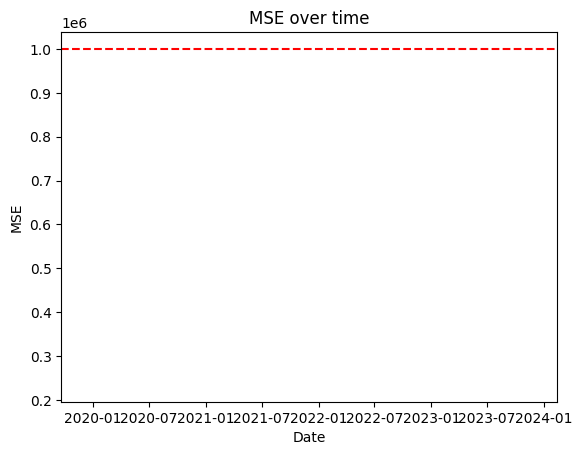

TypeError: expected str, bytes or os.PathLike object, not ndarray

In [100]:
def trigger_retrain(mean_error_threshold: float) -> None:

    mlflow.start_run(run_name="lstm data drift check")

    avg_error = 0
    list_of_errors = np.array([])
    list_of_dates = np.array([])
    threshold_broken = False

    for date, column in newdata.iterrows():

        clear_output(wait=True)

        with mlflow.start_run(nested=True, run_name=date.strftime("%Y-%m-%d")):
            day_data = column.to_frame().transpose()
            X, y = day_data.drop('Adj Close', axis=1), day_data[['Adj Close']]
            y_pred = model.predict(X)
            error = (y-y_pred) ** 2

            list_of_dates = np.append(list_of_dates, date)
            list_of_errors = np.append(list_of_errors, error)

            avg_error = np.average(list_of_errors)

            fig, ax = plt.subplots()
            ax.plot(list_of_dates, list_of_errors)
            ax.set_title('MSE over time')
            ax.set_xlabel('Date')
            ax.set_ylabel('MSE')
            ax.axhline(mean_error_threshold, color='r', linestyle='--')

            plt.show()
            mlflow.log_figure(fig, "mse.png")
            mlflow.log_artifact(np.column_stack((list_of_dates, list_of_errors)), artifact_path='errors')

            mlflow.log_metric("rolling_mse", avg_error)

        if avg_error > mean_error_threshold:
            threshold_broken = True
            break

    mlflow.end_run()
    clear_output(wait=True)

    if threshold_broken:
        print("Drift threshold exceeded. Retraining...")
        
        data_used = newdata[newdata.index <= (date)]
        all_data = pd.concat([data, data_used])
        runname = "aalstm_retrain"            
        train_model(all_data, n_epochs=1, test_size=25)
            

trigger_retrain(1000000)


